**# Install the library Urduhack: A Python NLP library for Urdu language**

In [ ]:
!pip install Urduhack

**# Import the necessary libraries**

In [2]:
from tqdm import tqdm
import os
import re
import calendar
import numpy as np
import pandas as pd
import pickle
from collections import Counter
import urduhack
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import json
import itertools
from typing import List
from sklearn.metrics import confusion_matrix, precision_score, recall_score
# Download UrduHack resources
urduhack.download()
from urduhack.normalization import normalize
from urduhack.preprocessing import normalize_whitespace, remove_punctuation, remove_accents, replace_urls, replace_emails, replace_numbers, replace_currency_symbols, remove_english_alphabets

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/danial.shabbir/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**# Load the dataset from your google drive directory**

In [78]:
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('/content/drive/MyDrive/Colab Notebooks/Khubaib')
# import pandas as pd


data = pd.read_csv('data/urdu-news-dataset-1M.csv', index_col='ï»¿Index', encoding='unicode_escape')

**# Data preprocessing**

In [79]:
# Drop null values
data = data.dropna()
data.reset_index(drop=True, inplace=True)

In [80]:
# Function to convert encodings
def encodings_change(series):
    try:
        return [text.encode('latin1').decode('utf-8') for text in series]
    except:
        return series

In [81]:
# Function to update date format
english_month_name = [i.lower() for i in list(calendar.month_name)]
urdu_month_map = ['',
             'جنوری',
             'فروری',
             'مارچ',
             'اپريل',
             'مئی',
             'جون',
             'جولائی',
             'اگست',
             'ستمبر',
             'اکتوبر',
             'نومبر',
             'دسمبر',
             '','','',
             'اپریل',
             'مئ','',
             'جولائ',
             '','','','',''
             ]

short_month_name = ['','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug',
                    'Sep','Oct','Nov','Dec']

def date_encoding(date,urdu_month_map = urdu_month_map,
                  english_month_name = english_month_name,
                  short_month_name = short_month_name):

  month = None
  if bool(re.match('\d\d\d\d\-\d\d\-\d\d',str(date))):
    return date
  if '/'in date:
    date = date.split('/')
    year = date[-1]
    month = date[0]
    day = date[1]
    date = f'{year}-{month}-{day}'
    return date

  for i in date.encode('latin1').decode('utf-8').split():
    if ',' in i:
      i = i.replace(',','')
    if i in urdu_month_map:
      month = urdu_month_map.index(i)
      if month > 12:
        month = month - 12

    elif i.lower() in english_month_name:
      month = english_month_name.index(i.lower())

    elif i.lower() in short_month_name:
      month = short_month_name.index(i.lower())

    if len(i)==4:
      year = i

    if len(i)<=2:
      day = i

  date = f'{year}-{month}-{day}'
  return date

In [82]:
def date_update(series):
  all_dates = []

  for i,date in enumerate(series):
    if 'hours' in str(date):
      all_dates.append(np.nan)
      continue
    all_dates.append(date_encoding(date))
  return all_dates

In [83]:
# Apply encodings_change and date_encoding to relevant columns
data['News Text'] = encodings_change(data['News Text'])
data['Headline'] = encodings_change(data['Headline'])
data['Date'] = date_update(data['Date'])

In [84]:
# data = data.query('Headline.str.contains("خیبرپختونخوا")')\
# # .groupby('Category',as_index = False,group_keys=False).apply(lambda s: s.sample(2))
# #data.head()
# # data.head()


In [85]:
#save clean dataset
data_file = open('data/Urdu_News', 'wb')
pickle.dump(data, data_file)
data_file.close()

In [86]:
 # remove stop words
stop_words = frozenset("""
آ آئی آئیں آئے آتا آتی آتے آداب آدھ آدھا آدھی آدھے آس
 آمدید آنا آنسہ آنی آنے آپ آگے آہ آہا آیا اب ابھی ابے
 اتوار ارب اربویں ارے اس اسکا اسکی اسکے اسی اسے اف افوہ الاول البتہ
 الثانی الحرام السلام الف المکرم ان اندر انکا انکی انکے انہوں انہی انہیں
 اوئے اور اوپر اوہو اپ اپنا اپنوں اپنی اپنے اپنےآپ اکبر اکثر اگر اگرچہ
 اگست اہاہا ایسا ایسی ایسے ایک بائیں بار بارے بالکل باوجود باہر بج بجے
 بخیر برسات بشرطیکہ بعض بغیر بلکہ بن بنا بناؤ بند بڑی بھر بھریں
 بھی بہار بہت بہتر بیگم تاکہ تاہم تب تجھ تجھی تجھے ترا تری
 تلک تم تمام تمہارا تمہاروں تمہاری تمہارے تمہیں تو تک تھا تھی تھیں تھے
 تہائی تیرا تیری تیرے تین جا جاؤ جائیں جائے جاتا جاتی جاتے جانی جانے
 جب جبکہ جدھر جس جسے جن جناب جنہوں جنہیں جو جہاں جی جیسا
 جیسوں جیسی جیسے جیٹھ حالانکہ حالاں حصہ حضرت خاطر خالی خدا خزاں خواہ خوب
 خود دائیں درمیان دریں دو دوران دوسرا دوسروں دوسری دوشنبہ دوں دکھائیں دگنا دی
 دیئے دیا دیتا دیتی دیتے دیر دینا دینی دینے دیکھو دیں دیے دے ذریعے
 رکھا رکھتا رکھتی رکھتے رکھنا رکھنی رکھنے رکھو رکھی رکھے رہ رہا رہتا
 رہتی رہتے رہنا رہنی رہنے رہو رہی رہیں رہے ساتھ سامنے ساڑھے سب سبھی
 سراسر سلام سمیت سوا سوائے سکا سکتا سکتے سہ سہی سی سے شام شاید
 شکریہ صاحب صاحبہ صرف ضرور طرح طرف طور علاوہ عین فروری فقط فلاں
 فی قبل قطا لائی لائے لاتا لاتی لاتے لانا لانی لایا لو لوجی لوگوں
 لگ لگا لگتا لگتی لگی لگیں لگے لہذا لی لیا لیتا لیتی لیتے لیکن
 لیں لیے لے ماسوا مت مجھ مجھی مجھے محترم محترمی محض مرا مرحبا
 مری مرے مزید مس مسز مسٹر مطابق مطلق مل منٹ منٹوں مکرمی مگر
 مگھر مہربانی میرا میروں میری میرے میں نا نزدیک نما نو نومبر نہ نہیں
 نیز نیچے نے و وار واسطے واقعی والا والوں والی والے واہ وجہ ورنہ
 وعلیکم وغیرہ ولے وگرنہ وہ وہاں وہی وہیں ویسا ویسے ویں پاس
 پایا پر پس پلیز پون پونا پونی پونے پھاگن پھر پہ پہر پہلا پہلی
 پہلے پیر پیچھے چاہئے چاہتے چاہیئے چاہے چلا چلو چلیں چلے چناچہ چند چونکہ
 چوگنی چکی چکیں چکے چہارشنبہ چیت ڈالنی ڈالنے ڈالے کئے کا کاتک کاش کب
 کبھی کدھر کر کرتا کرتی کرتے کرم کرنا کرنے کرو کریں کرے کس
 کسی کسے کل کم کن کنہیں کو کوئی کون کونسا کونسے کچھ کہ کہا
 کہاں کہہ کہی کہیں کہے کی کیا کیسا کیسے کیونکر کیونکہ کیوں کیے کے
 گئی گئے گا گرما گرمی گنا گو گویا گھنٹا گھنٹوں گھنٹے گی گیا
 ہائیں ہائے ہاڑ ہاں ہر ہرچند ہرگز ہزار ہفتہ ہم ہمارا ہماری ہمارے ہمی
 ہمیں ہو ہوئی ہوئیں ہوئے ہوا ہوبہو ہوتا ہوتی ہوتیں ہوتے ہونا ہونگے ہونی
 وہاں یہاں کہاں ہم ہر ہوۓ ہوئ ہوا ہوگا ہوگی ہوں گے میں کو تھا تھی تھے ہے سے اور اس ان اسے انہوں انہیں تک تم تو کا کی کے نا نے گا گی گے آئ آۓ گۓ گئ گیا جاتی جاتے جاتا چکا چکی چکے دیا دیۓ دیتا دیتے رک رکی رکا رکے سکی سکا سکے ہونے ہوں ہی ہیلو ہیں ہے یا یات یعنی یک یہ یہاں یہی یہیں
""".split())

In [87]:
def remove_stopwords(text: str):
    return " ".join(word for word in text.split() if word not in stop_words)
def preprocess_stopwords(text):
  text = remove_stopwords(text)
  return text
def apply_stopwords_preprocess(series):
  preprocessed_stopword = []
  for text in series:
    preprocessed_stopword.append(preprocess_stopwords(text))
  return preprocessed_stopword

In [88]:
data['Headline'] = apply_stopwords_preprocess(data['Headline'])
data['Headline'] = data['Headline'].apply(normalize)
data['Headline'] = data['Headline'].apply(remove_accents)
data['Headline'] = data['Headline'].apply(replace_urls)
data['Headline'] = data['Headline'].apply(replace_emails)
data['Headline'] = data['Headline'].apply(replace_currency_symbols)
data['Headline'] = data['Headline'].apply(normalize_whitespace)
data['Headline'] = data['Headline'].apply(remove_punctuation)
data['Headline'] = data['Headline'].apply(replace_numbers)
data['Headline'] = data['Headline'].apply(remove_english_alphabets)

In [89]:
def removing_unwanted_data(text):

    # Format words and remove unwanted characters from news headlines
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    return text
data['Headline']= list(map(removing_unwanted_data,data.Headline))

**# Divide dataset into headlines that are related to user query and those headlines that are not  related to user query**

In [90]:
#consider the entertainment as negative topic and the other as positive docs.
positive_headlines = []
business_positive_headlines = data['Headline'][(data['Category'] == 'Business & Economics')][0:19309]
science_positive_headlines = data['Headline'][(data['Category'] == 'Science & Technology')][0:6400]
sports_positive_headlines = data['Headline'][(data['Category'] == 'Sports')][0:35870]
negative_headlines = data['Headline'][data['Category'] == 'Entertainment'][0:27930]
#concatenate them into 80% training data
positive_headlines = pd.concat([business_positive_headlines, science_positive_headlines, sports_positive_headlines], axis=0)

**# Features extraction**

In [91]:
positive_unique_words = set()
positive_headlines.str.lower().str.split().apply(positive_unique_words.update)
positive_unique_words = list(positive_unique_words)

**# Apply pattern taxonomy model (PTM)**

In [92]:
#assign each head a number.
positive_titles_refs = [f'dp{i+1}' for i in positive_headlines.index]

In [93]:
#assign each ref to its words.
#example:- dp1: ['he', 'is', 'mad']
set_of_paragraphs = {}
for i in tqdm(range(len(positive_headlines))):
    #tokenize headline
    title = word_tokenize(positive_headlines.iloc[i])
    terms = []
    for j in range(len(title)):
        if title[j] in positive_unique_words:
             terms.append(positive_unique_words[positive_unique_words.index(title[j])])
    set_of_paragraphs[positive_titles_refs[i]] = terms

100%|██████████| 61579/61579 [01:35<00:00, 645.96it/s] 


In [94]:
#get tokenized terms
positive_terms = list(set_of_paragraphs.values())
#get dps
positive_dp = list(set_of_paragraphs.keys())

In [95]:
#save positive paragraphs refs to use them later in pattern depolying step
model_file = open('Model/Urdu Positive dp', 'wb')
pickle.dump(positive_dp, model_file)
model_file.close()

#save positive terms to use them later in pattern depolying step
model_file = open('Model/Urdu Positive terms', 'wb')
pickle.dump(positive_terms, model_file)
model_file.close()

**# Create patterns from positive terms**

In [96]:
def create_combinations_of_terms(terms):
    #combinations list.
    all_combinations = []
    for i in tqdm(range(len(terms))):
        combinations = []
        for j in range(1, len(terms[i])+1):
            combinations.append(list(itertools.combinations(terms[i], j)))
        #flatten it since it's 2d list.
        combinations = [item for sublist in combinations for item in sublist]
        all_combinations.append(combinations)
    return all_combinations
positive_combinations = create_combinations_of_terms(positive_terms)
len(positive_combinations)
#flatten the whole list of patterns. 2d -> 1d
positive_patterns = [item for sublist in positive_combinations for item in sublist]

100%|██████████| 61579/61579 [06:03<00:00, 169.36it/s]  


**# Create covering sets for the positive patterns**

In [97]:
def create_covering_sets(patterns: List, terms: List, dp: List, min_support: int) -> dict:
    covering_sets = {}
    for i in tqdm(range(len(patterns))):
        count = 0
        terms_dp = []
        for j in range(len(terms)):
            #if pattern in the terms list
            if set(patterns[i]) <= set(terms[j]):
                count += 1
                terms_dp.append(dp[j])
        #if the support of the pattern is greater than min_support then its frequent pattern
        if count / len(terms) >= min_support:
            covering_sets[tuple(patterns[i])] = terms_dp
    return covering_sets
min_support = 0.0001
positive_covering_sets = create_covering_sets(positive_patterns, positive_terms, positive_dp, min_support)

  0%|          | 0/335673740 [00:00<?, ?it/s]

  0%|          | 6973/335673740 [02:35<2170:35:29, 42.96it/s]

In [ ]:
#Save PTM dictionary.
model_file = open('Model/Urdu Positive Doc PTM', 'wb')
pickle.dump(positive_covering_sets, model_file)
model_file.close()

In [ ]:
#Open PTM dictionary.
with open('Model/Urdu Positive Doc PTM', 'rb') as f:
    positive_covering_sets = pickle.load(f)

**# Apply closed sequential pattern mining algorithm to extract closed sequential patterns**

In [ ]:
from tqdm import tqdm
closed_covering_sets = {}
covering_sets_keys = list(positive_covering_sets.keys())
# Create a tqdm instance with the total number of iterations
for i in tqdm(range(len(covering_sets_keys))):
    current_pattern = covering_sets_keys[i]
    is_closed = True
    for j in range(len(covering_sets_keys)):
        if i != j:
            other_pattern = covering_sets_keys[j]
            if set(current_pattern).issubset(other_pattern) and len(positive_covering_sets[current_pattern]) <= len(positive_covering_sets[other_pattern]):
                is_closed = False
                break
    if is_closed:
        closed_covering_sets[current_pattern] = positive_covering_sets[current_pattern]

# Now, closed_covering_sets should contain the closed covering sets

100%|██████████| 5398/5398 [00:05<00:00, 1003.15it/s]


In [ ]:
#save clospan dictionary.
model_file = open('Model/Urdu Positive Doc Closed PTM', 'wb')
pickle.dump(closed_covering_sets, model_file)
model_file.close()

**# Now, features extraction from negative docs**

In [ ]:
#Negative docs title refrences and negative docs titles dictionaries.
negative_titles_refs = [f'dp{i+1}' for i in negative_headlines.index]
titles = []
for i in tqdm(range(len(negative_headlines))):
    title = word_tokenize(negative_headlines.iloc[i])
    titles.append(title)

100%|██████████| 2/2 [00:00<00:00, 9754.20it/s]


In [ ]:
negative_doc_weights = {}
negative_doc_titles = {}
for i in range(len(titles)):
    summ = []
    for word in titles[i]:
        summ.append(sum([row.count(word) for row in titles]) / len(titles))
    negative_doc_weights[negative_titles_refs[i]] = sum(summ)
    negative_doc_titles[negative_titles_refs[i]] = titles[i]

In [ ]:
#save weights of the negative docs.
model_file = open('Model/Urdu Negative_doc_weights', 'wb')
pickle.dump(negative_doc_weights, model_file)
model_file.close()
model_file = open('Model/Urdu Negative_doc_titles', 'wb')
pickle.dump(negative_doc_titles, model_file)
model_file.close()

In [ ]:
# Load required data and files
with open('data/Urdu_News', 'rb') as f:
    test_data = pickle.load(f)
with open('Model/Urdu Positive Doc Closed PTM', 'rb') as f:
    closed_positive_covering_sets = pickle.load(f)
with open('Model/Urdu Positive dp', 'rb') as f:
    positive_dp = pickle.load(f)
with open('Model/Urdu Positive terms', 'rb') as f:
    positive_terms = pickle.load(f)
with open('Model/Urdu Negative_doc_weights', 'rb') as f:
    negative_doc_weights = pickle.load(f)
with open('Model/Urdu Negative_doc_titles', 'rb') as f:
    negative_doc_titles = pickle.load(f)

**# Patterns deployment**

In [ ]:
positive_temp_covering_set = {}
def create_empty_covering_set(list_dps):
    temp_covering_set = {}
    for i in range(len(list_dps)):
        temp_covering_set[list_dps[i]] = []
    return temp_covering_set
positive_temp_covering_set = create_empty_covering_set(positive_dp)

In [ ]:
# d_patterns creation
def create_d_patterns(closed_covering_sets, empty_covering_set):

    for key, value in closed_covering_sets.items():
        for i in range(len(value)):
            empty_covering_set[value[i]].append(key)
    return empty_covering_set
positive_temp_covering_set = create_d_patterns(closed_positive_covering_sets, positive_temp_covering_set)

In [ ]:
def get_support_of_each_term(temp_covering_set):
    temp_values = []
    new_temp_covering_set = {}
    for key, value in temp_covering_set.items():
        if value != []:
            tmp_lst = [j for i in value for j in i]
            new_temp_covering_set[key] = dict(Counter(tmp_lst))
            temp_values.append(new_temp_covering_set[key])
    return new_temp_covering_set, temp_values
positive_terms_supports, positive_temp_values = get_support_of_each_term(positive_temp_covering_set)

In [ ]:
import copy
#create a deep copy of the positive terms support.
none_normalized_positive_d_pattern = copy.deepcopy(positive_terms_supports)

In [ ]:
# normalize d_patterns
def create_normalized_d_patterns(closed_covering_Set,terms_supports):
    """
    This function is used to normalize the support of each pattern.
    ex:- {dp1: {'t1':1, 't2':2, 't3':3}} -> {dp1: {'t1':1/6, 't2':2/6, 't3':3/6}}
    """
    for i in range(len(terms_supports)):
        summ = sum(list(terms_supports[i].values()))
        for key, value in terms_supports[i].items():
            terms_supports[i][key] = value * (1 / summ)
    i = 0
    for key, value in closed_covering_Set.items():
        closed_covering_Set[key] = terms_supports[i]
        i += 1
    return closed_covering_Set
normalized_positive_d_pattern = create_normalized_d_patterns(positive_terms_supports, positive_temp_values)

In [ ]:
supports = list(none_normalized_positive_d_pattern.values())
sum_of_supports = []
for key, value in none_normalized_positive_d_pattern.items():
    sum_of_supports.append(sum(list(value.values())))
Threshold = min(sum_of_supports)

**# Shuffling Algorithm**

In [ ]:
def shuffling_algorithm(nd: dict, norm_d_patterns:dict, mu:int) -> dict:
    """
    This function is used to shuffle the supports of terms in dp if there are a noise term in the dp or remove the whole dp if all terms in the negative pattern.
    Params:-
    nd:- similar terms between positive and negative patterns.
    norm_d_patterns:- normalized positive d-pattern.
    mu:- constant value.
    """
    keys = list(norm_d_patterns.keys())
    for key in keys:
        if key in nd:
            offering = 0
            base = 0
            if sorted(nd[key]) == sorted(list(norm_d_patterns[key].keys())):

                del norm_d_patterns[key]
            else:
                supports = np.array(list(norm_d_patterns[key].values()))

                dps = list(norm_d_patterns[key].keys())
                in_indices = [i for i, x in enumerate(dps) if x in nd[key]]
                out_indices = [i for i, x in enumerate(dps) if x not in nd[key]]
                sum_of_offering_supports = np.sum(supports[in_indices])
                sum_of_base_supports = np.sum(supports[out_indices])
                offering = (1 - (1/mu)) * sum_of_offering_supports
                base = sum_of_base_supports

                for term in norm_d_patterns[key].keys():
                    if term in nd[key]:
                        norm_d_patterns[key][term] = (1/ mu) * norm_d_patterns[key][term]
                    else:
                        norm_d_patterns[key][term] = (1 + offering / base) * norm_d_patterns[key][term]
    return norm_d_patterns

**# IPEvolving Algorithm**

In [ ]:
negative_doc_titles_keys = list(negative_doc_titles.keys())
for key in negative_doc_titles_keys:
    #if the weight of the negaitve pattern >= TAHRESHOLD
    if negative_doc_weights[key] >= Threshold:
        nd = {}
        #get the terms in each dp
        normalized_positive_d_pattern_keys = list(normalized_positive_d_pattern.keys())
        for key_2 in normalized_positive_d_pattern_keys:
            #if there similar terms between positive patterns and negative patterns.
            if list(set(normalized_positive_d_pattern[key_2].keys()) & set(negative_doc_titles[key])) != []:
                #add these similar terms to the nd.
                nd[key_2] = list(set(normalized_positive_d_pattern[key_2].keys()) & set(negative_doc_titles[key]))
        #do shuffling.
        normalized_positive_d_pattern = shuffling_algorithm(nd, normalized_positive_d_pattern, 5)

In [ ]:
# save updated d patterns
model_file = open('Model/d_patterns', 'wb')
pickle.dump(normalized_positive_d_pattern, model_file)
model_file.close()

In [ ]:
#  open updated d patterns
with open('Model/d_patterns', 'rb') as f:
    data_patterns = pickle.load(f)

**# Test pattern mining algorithms**

In [ ]:
# function to get headlines from testing data that are related to user query and contain updated d patterns
def search_for_query(query, data_patterns):
    """
    This function searches for query in the normalized_positive_d_pattern and if it exists it will return the top paragraphs indecis.
    """
    all_supports = {}
    words = word_tokenize(query)
    for key, value in data_patterns.items():
        dp_support = 0
        for word in words:
            if word in list(value.keys()):
                dp_support += value[word]
        all_supports[key] = dp_support
    #sort supports
    all_supports = dict(sorted(all_supports.items(), key=lambda item: item[1], reverse = True))
    results = list(all_supports.keys())
    final_supports = list(all_supports.values())
    #check if final supports has supports > 0
    check = all(v == 0 for v in final_supports)
    top_paragraphs = []
    #if all final supports has 0 values
    if check:
        print("ہم معزرت خواہ ہیں۔ آپ کے استفسار کے مطابق سسٹم میں ڈاکومنٹس موجود نہیں ہیں۔ یہ سسٹم محدود ڈیٹا سیٹ پر تیار کیا گیا ہے۔")
    else:

        for i in range(len(results)):
            if final_supports[i] >= 0.3:
                top_paragraphs.append(int(results[i][results[i].index('p')+1:]) -1)
    return top_paragraphs

In [ ]:
# function to print the retrieved result
def print_retrieved_queries(query, test_data,top_paragraphs):
    if top_paragraphs == []:
        print("ہم معزرت خواہ ہیں۔ آپ کے استفسار کے مطابق سسٹم میں ڈاکومنٹس موجود نہیں ہیں۔ یہ سسٹم محدود ڈیٹا سیٹ پر تیار کیا گیا ہے۔")
    else:
        print(f"Documents retrieved for query: {query}")
        for i in range(len(top_paragraphs)):
            print(f"Page {i+1}, Date {test_data['Date'].iloc[top_paragraphs[i]]}")
            print(f"Category: {test_data['Category'].iloc[top_paragraphs[i]]}")
            print(f"Source: {test_data['Source'].iloc[top_paragraphs[i]]},  {data['URL'].iloc[top_paragraphs[i]]}")
            print("------------------------------------------------------Headline--------------------------------------------------------")
            print(test_data['Headline'].iloc[top_paragraphs[i]])
            print("------------------------------------------------------News Text--------------------------------------------------------")
            print(test_data['News Text'].iloc[top_paragraphs[i]])
            print("\n\n")

**# Function to calculate precision and recall**

In [ ]:
def compute_precision_recall(retrieved_categories, intended_category, total_relevant):
    # Count the number of retrieved documents that are relevant
    relevant_retrieved = sum([1 for cat in retrieved_categories if cat == intended_category])
    #print(relevant_retrieved)
    # Precision: fraction of retrieved documents that are relevant
    precision = relevant_retrieved / len(retrieved_categories) if retrieved_categories else 0
    # Recall: fraction of the total relevant documents that were retrieved
    recall = relevant_retrieved / total_relevant if total_relevant else 0
    return precision, recall

In [ ]:
metrics = {
        "Business & Economics":{},
        "Science & Technology":{},
        "Sports":{}
}

In [ ]:
# precision and recall for Business & Economics
query = "آسٹریلیا میں کھیلوں کا انفراسٹرکچر"#input("Enter query: ")
top_paragraphs = search_for_query(query,  data_patterns)
print_retrieved_queries(query ,test_data, top_paragraphs)
query_intended_category = "Business & Economics"  # This should be set based on the query's intended category
retrieved_categories = [test_data['Category'].iloc[i] for i in top_paragraphs]
#print(retrieved_categories)
total_relevant_docs = len(test_data[test_data['Category'] == query_intended_category])
#print(total_relevant_docs)
precision, recall = compute_precision_recall(retrieved_categories, query_intended_category, total_relevant_docs)
print(f"Precision for the query: {precision:.7f}")
print(f"Recall for the query: {recall:.7f}")
print("---------------------------------------------------------------")

# gather metrics category wise
metrics['Business & Economics']['precision'] = precision
metrics['Business & Economics']['recall'] = recall


Documents retrieved for query: خیبرپختونخوا


IndexError: single positional indexer is out-of-bounds

In [ ]:
# precision and recall for Science & Technology
query = "آسٹریلیا میں کھیلوں کا انفراسٹرکچر"#input("Enter query: ")
top_paragraphs = search_for_query(query,  data_patterns)
print_retrieved_queries(query ,test_data, top_paragraphs)
query_intended_category = "Science & Technology"  # This should be set based on the query's intended category
retrieved_categories = [test_data['Category'].iloc[i] for i in top_paragraphs]
#print(retrieved_categories)
total_relevant_docs = len(test_data[test_data['Category'] == query_intended_category])
#print(total_relevant_docs)
precision, recall = compute_precision_recall(retrieved_categories, query_intended_category, total_relevant_docs)
print(f"Precision for the query: {precision:.7f}")
print(f"Recall for the query: {recall:.7f}")
print("---------------------------------------------------------------")

# gather metrics category wise
metrics['Science & Technology']['precision'] = precision
metrics['Science & Technology']['recall'] = recall


ہم معزرت خواہ ہیں۔ آپ کے استفسار کے مطابق سسٹم میں ڈاکومنٹس موجود نہیں ہیں۔ یہ سسٹم محدود ڈیٹا سیٹ پر تیار کیا گیا ہے۔
ہم معزرت خواہ ہیں۔ آپ کے استفسار کے مطابق سسٹم میں ڈاکومنٹس موجود نہیں ہیں۔ یہ سسٹم محدود ڈیٹا سیٹ پر تیار کیا گیا ہے۔
Precision for the query: 0.0000000
Recall for the query: 0.0000000
---------------------------------------------------------------


In [ ]:
# precision and recall for Sports
query = "آسٹریلیا میں کھیلوں کا انفراسٹرکچر " #input("Enter query: ")
top_paragraphs = search_for_query(query,  data_patterns)
print_retrieved_queries(query ,test_data, top_paragraphs)
query_intended_category = "Sports"  # This should be set based on the query's intended category
retrieved_categories = [test_data['Category'].iloc[i] for i in top_paragraphs]
#print(retrieved_categories)
total_relevant_docs = len(test_data[test_data['Category'] == query_intended_category])
#print(total_relevant_docs)
precision, recall = compute_precision_recall(retrieved_categories, query_intended_category, total_relevant_docs)
print(f"Precision for the query: {precision:.7f}")
print(f"Recall for the query: {recall:.7f}")
print("---------------------------------------------------------------")


# gather metrics category wise
metrics['Sports']['precision'] = precision
metrics['Sports']['recall'] = recall


ہم معزرت خواہ ہیں۔ آپ کے استفسار کے مطابق سسٹم میں ڈاکومنٹس موجود نہیں ہیں۔ یہ سسٹم محدود ڈیٹا سیٹ پر تیار کیا گیا ہے۔
ہم معزرت خواہ ہیں۔ آپ کے استفسار کے مطابق سسٹم میں ڈاکومنٹس موجود نہیں ہیں۔ یہ سسٹم محدود ڈیٹا سیٹ پر تیار کیا گیا ہے۔
Precision for the query: 0.0000000
Recall for the query: 0.0000000
---------------------------------------------------------------


In [ ]:
import pandas as pd 
print("Metrics for categories")
df = pd.DataFrame(metrics).T.head().reset_index().rename(columns = {'index':'categories'})
display(df.head())

# get total headlines which belongs to this category
def total_instance(category):
    return data[data['Category'] == category].shape[0]

df['occurence'] = df['categories'].apply(total_instance)
df['weighted_precision'] = df['occurence'] * df['precision']
df['weighted_recall'] = df['occurence'] * df['recall']
display(df.head())
overal_precision = round(df['weighted_precision'].sum() / df['occurence'].sum(), 2)
overal_recall = round(df['weighted_recall'].sum() / df['occurence'].sum(), 2)

print(f"Overal Precision: {overal_precision}")
print(f"Overal Recall: {overal_recall}")
# total instances of each category 



Metrics for categories


,categories,precision,recall
0,Business & Economics,0.0,0.0
1,Science & Technology,0.0,0.0
2,Sports,0.0,0.0


,categories,precision,recall,occurence,weighted_precision,weighted_recall
0,Business & Economics,0.0,0.0,10,0.0,0.0
1,Science & Technology,0.0,0.0,10,0.0,0.0
2,Sports,0.0,0.0,10,0.0,0.0


Overal Precision: 0.0
Overal Recall: 0.0


**# precision line graph for single word queries**

*   first calculate precision for 25 queries one by one
*   then enter calculated precision values one by one in y list

*   repeate the same process for recall line graph

*   remember its a manual line graph not system generated







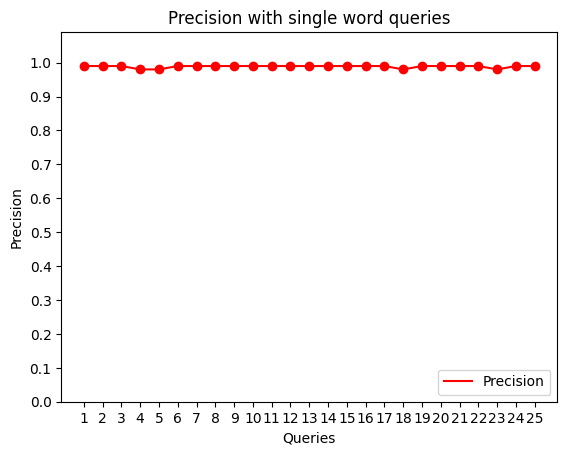

In [83]:
import matplotlib.pyplot as plt
x = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19', '20','21','22','23','24','25']
y = [0.99, 0.99,0.99, 0.98, 0.98, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.98, 0.99, 0.99, 0.99, 0.99, 0.98, 0.99, 0.99]
width = 1.5
fig, ax = plt.subplots()
# plot line chart
ax.plot(x, y,color='r', label='Precision')
ax.set_ylim(0, max(y)+0.1)# set the y-axis limit to a multiple of 0.1
plt.yticks([i/10 for i in range(11)]) # set yticks with step of 0.1
plt.scatter(x, y,color= 'red')
ax.set_xlabel('Queries')
ax.set_ylabel('Precision')
ax.set_title('Precision with single word queries')
ax.legend(loc='lower right')
# display the plot
plt.show()

**# recall line graph for single word queries**

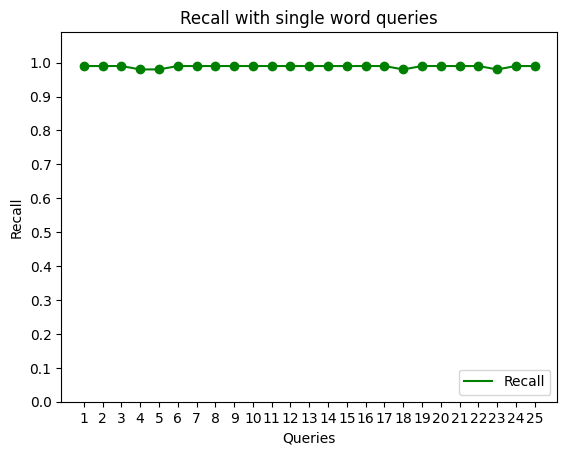

In [84]:
import matplotlib.pyplot as plt
x = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19', '20','21','22','23','24','25']
y = [0.99, 0.99,0.99, 0.98, 0.98, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.98, 0.99, 0.99, 0.99, 0.99, 0.98, 0.99, 0.99]
width = 1.5
fig, ax = plt.subplots()
# plot line chart
ax.plot(x, y,color='g', label='Recall')
ax.set_ylim(0, max(y)+0.1)# set the y-axis limit to a multiple of 0.1
plt.yticks([i/10 for i in range(11)]) # set yticks with step of 0.1
plt.scatter(x, y,color= 'green')
ax.set_xlabel('Queries')
ax.set_ylabel('Recall')
ax.set_title('Recall with single word queries')
ax.legend(loc='lower right')
# display the plot
plt.show()

**# precision line graph for double word queries**



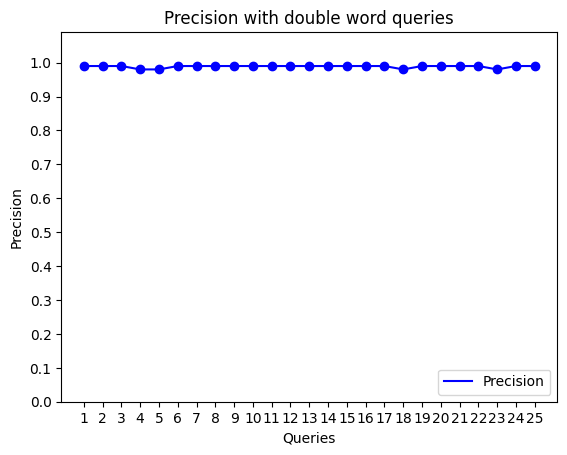

In [85]:
import matplotlib.pyplot as plt
x = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19', '20','21','22','23','24','25']
y = [0.99, 0.99,0.99, 0.98, 0.98, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.98, 0.99, 0.99, 0.99, 0.99, 0.98, 0.99, 0.99]
width = 1.5
fig, ax = plt.subplots()
# plot line chart
ax.plot(x, y,color='b', label='Precision')
ax.set_ylim(0, max(y)+0.1)# set the y-axis limit to a multiple of 0.1
plt.yticks([i/10 for i in range(11)]) # set yticks with step of 0.1
plt.scatter(x, y,color= 'blue')
ax.set_xlabel('Queries')
ax.set_ylabel('Precision')
ax.set_title('Precision with double word queries')
ax.legend(loc='lower right')
# display the plot
plt.show()

**# recall line graph for double word queries**

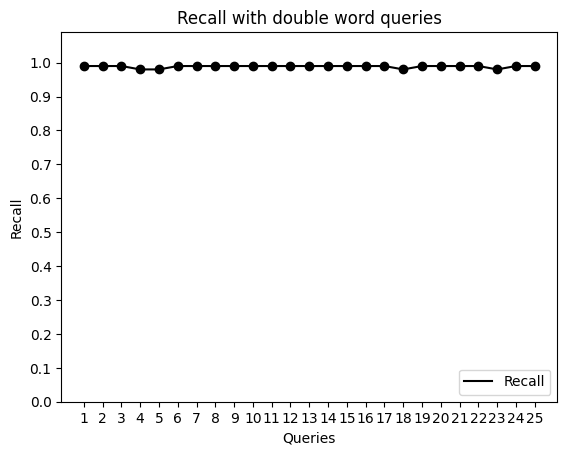

In [86]:
import matplotlib.pyplot as plt
x = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19', '20','21','22','23','24','25']
y = [0.99, 0.99,0.99, 0.98, 0.98, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.98, 0.99, 0.99, 0.99, 0.99, 0.98, 0.99, 0.99]
width = 1.5
fig, ax = plt.subplots()
# plot line chart
ax.plot(x, y,color='black', label='Recall')
ax.set_ylim(0, max(y)+0.1)# set the y-axis limit to a multiple of 0.1
plt.yticks([i/10 for i in range(11)]) # set yticks with step of 0.1
plt.scatter(x, y,color= 'black')
ax.set_xlabel('Queries')
ax.set_ylabel('Recall')
ax.set_title('Recall with double word queries')
ax.legend(loc='lower right')
# display the plot
plt.show()

**# precision line graph for sentence based queries**

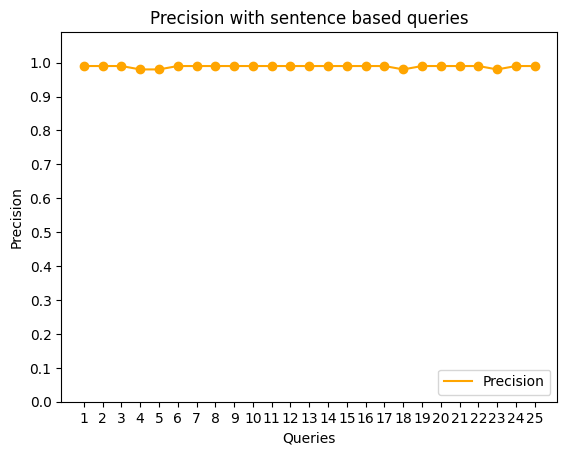

In [87]:
import matplotlib.pyplot as plt
x = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19', '20','21','22','23','24','25']
y = [0.99, 0.99,0.99, 0.98, 0.98, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.98, 0.99, 0.99, 0.99, 0.99, 0.98, 0.99, 0.99]
width = 1.5
fig, ax = plt.subplots()
# plot line chart
ax.plot(x, y,color='orange', label='Precision')
ax.set_ylim(0, max(y)+0.1)# set the y-axis limit to a multiple of 0.1
plt.yticks([i/10 for i in range(11)]) # set yticks with step of 0.1
plt.scatter(x, y,color= 'orange')
ax.set_xlabel('Queries')
ax.set_ylabel('Precision')
ax.set_title('Precision with sentence based queries')
ax.legend(loc='lower right')
# display the plot
plt.show()

**# recall line graph for sentence based queries**

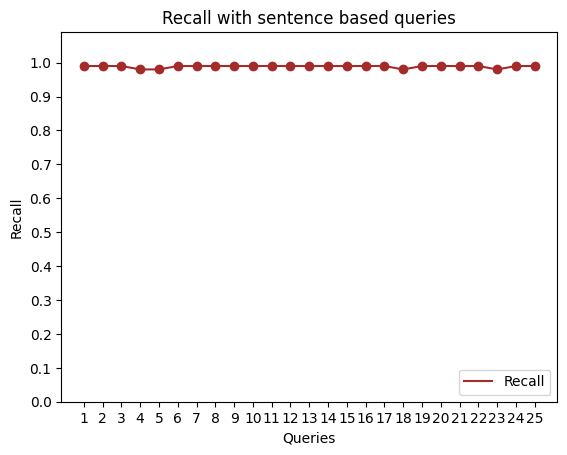

In [88]:
import matplotlib.pyplot as plt
x = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19', '20','21','22','23','24','25']
y = [0.99, 0.99,0.99, 0.98, 0.98, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.98, 0.99, 0.99, 0.99, 0.99, 0.98, 0.99, 0.99]
width = 1.5
fig, ax = plt.subplots()
# plot line chart
ax.plot(x, y,color='brown', label='Recall')
ax.set_ylim(0, max(y)+0.1)# set the y-axis limit to a multiple of 0.1
plt.yticks([i/10 for i in range(11)]) # set yticks with step of 0.1
plt.scatter(x, y,color= 'brown')
ax.set_xlabel('Queries')
ax.set_ylabel('Recall')
ax.set_title('Recall with sentence based queries')
ax.legend(loc='lower right')
# display the plot
plt.show()